In [1]:
import urllib.request #发送请求
from urllib import parse #URL编码
import json #解析json数据
import jsonpath #提取json数据
import pandas as pd #导入pandas库
import numpy as np
import pickle

In [2]:
LBSkey = '5f4a9713e41c83183b72817fb3acb428'
POIkey = '9ad58ff9754b6fe3c7e51f43c06f453f'
mykey = 'd63d7e23659a45277696c954da708d42'

In [3]:
stationInfo = pd.read_csv('../../Metro/station_transInfo_cleaned.csv')
dict_staionName = dict(zip(stationInfo['stationID'], stationInfo['name']))
dict_stationLoc = dict(zip(stationInfo['stationID'], zip(stationInfo['lon'],stationInfo['lat'])))
stationID_List = list(stationInfo['stationID'])

travelTime = np.zeros((len(stationID_List), len(stationID_List)))

In [4]:
with open('TempData/dict_stationPOI_Recorrect.pkl', 'rb') as f:
    dict_stationPOI = pickle.load(f)

with open('TempData/travelTime.pkl', 'rb') as f:
    travelTime = pickle.load(f)

with open('TempData/travelDis.pkl', 'rb') as f:
    travelDis = pickle.load(f)

with open("TempData/problematic_stationPair.pkl", 'rb') as f:
    problematic_StationPair = pickle.load(f)

In [5]:
def getTravelTimeV2(origin_ID, destination_ID, originpoi, destinationpoi, dict_stationLoc): #2.0; 地铁图模式
    url = 'https://restapi.amap.com/v5/direction/transit/integrated?'
    params = {
        'key': LBSkey,
        'originpoi': originpoi,
        'destinationpoi': destinationpoi,
        'origin': str(dict_stationLoc[origin_ID][0])[:9] + ',' + str(dict_stationLoc[origin_ID][1])[:8],
        'destination': str(dict_stationLoc[destination_ID][0])[:9] + ',' + str(dict_stationLoc[destination_ID][1])[:8],
        'strategy': 6,
        'nightflag': 0,
        'date': '2017-08-31',
        'time': '9-54',
        'city1': '021',
        'city2': '021',
        'show_fields': 'cost'
    }
    
    params = parse.urlencode(params)
    url = url + params
    #print(url)
    response = urllib.request.urlopen(url)
    content = response.read().decode('utf-8')
    data = json.loads(content)


    return data

In [6]:
origin_ID , destination_ID = problematic_StationPair[0]
origin_POI = dict_stationPOI[origin_ID]
destination_POI = dict_stationPOI[destination_ID]
TravelPlanFeedback = getTravelTimeV2(origin_ID, destination_ID, origin_POI, destination_POI, dict_stationLoc)
TravelPlanFeedback

{'status': '1',
 'info': 'OK',
 'infocode': '10000',
 'route': {'origin': '121.34259,31.19351',
  'destination': '121.75101,31.20143',
  'distance': '',
  'cost': {},
  'transits': []},
 'count': '0'}

用地铁图模式查不到的，用地图模式查

In [7]:
def getTravelTimeV3(origin_ID, destination_ID, originpoi, destinationpoi, dict_stationLoc): #2.0; 地图模式
    url = 'https://restapi.amap.com/v5/direction/transit/integrated?'
    params = {
        'key': LBSkey,
        'originpoi': originpoi,
        'destinationpoi': destinationpoi,
        'origin': str(dict_stationLoc[origin_ID][0])[:9] + ',' + str(dict_stationLoc[origin_ID][1])[:8],
        'destination': str(dict_stationLoc[destination_ID][0])[:9] + ',' + str(dict_stationLoc[destination_ID][1])[:8],
        'nightflag': 0,
        'date': '2017-08-31',
        'time': '12-00',
        'city1': '021',
        'city2': '021',
        'show_fields': 'cost'
    }
    
    params = parse.urlencode(params)
    url = url + params
    #print(url)
    response = urllib.request.urlopen(url)
    content = response.read().decode('utf-8')
    data = json.loads(content)


    return data

In [8]:
origin_ID , destination_ID = problematic_StationPair[0]
origin_POI = dict_stationPOI[origin_ID]
destination_POI = dict_stationPOI[destination_ID]
TravelPlanFeedback = getTravelTimeV3(origin_ID, destination_ID, origin_POI, destination_POI, dict_stationLoc)
TravelPlanFeedback

{'status': '1',
 'info': 'OK',
 'infocode': '10000',
 'route': {'origin': '121.346748,31.191738',
  'destination': '121.755301,31.199385',
  'distance': '38896',
  'cost': {'taxi_fee': '220'},
  'transits': [{'cost': {'duration': '7635', 'transit_fee': '9.0'},
    'distance': '51476',
    'walking_distance': '861',
    'nightflag': '0',
    'segments': [{'walking': {'destination': '121.347603,31.193884',
       'distance': '455',
       'origin': '121.346748,31.191736',
       'cost': {'duration': '390'},
       'steps': [{'instruction': '步行152米右转', 'road': '', 'distance': '152'},
        {'instruction': '步行22米左转', 'road': '', 'distance': '22'},
        {'instruction': '步行162米左转', 'road': '', 'distance': '162'},
        {'instruction': '沿虹桥路步行39米右转', 'road': '虹桥路', 'distance': '39'},
        {'instruction': '步行22米右转', 'road': '', 'distance': '22'},
        {'instruction': '步行58米到达虹桥机场1号航站楼', 'road': '', 'distance': '58'}]},
      'bus': {'buslines': [{'departure_stop': {'name': '虹桥机场1号

In [9]:
print(dict_staionName[origin_ID], dict_staionName[destination_ID])

虹桥1号航站楼 远东大道


In [10]:
from tqdm import tqdm
for i in tqdm(range(len(problematic_StationPair))):
    origin_ID , destination_ID = problematic_StationPair[i]
    origin_POI = dict_stationPOI[origin_ID]
    destination_POI = dict_stationPOI[destination_ID]

    origin_idx = stationID_List.index(origin_ID) #i
    destination_idx = stationID_List.index(destination_ID) #j

    TravelPlanFeedback = getTravelTimeV3(origin_ID, destination_ID, origin_POI, destination_POI, dict_stationLoc)

    if TravelPlanFeedback['status'] == '1':
        duration_pool = []   
        distance_pool = []
        for travelPlan  in TravelPlanFeedback['route']['transits']:
            duration_pool.append(int(travelPlan['cost']['duration']))
            distance_pool.append(int(travelPlan['distance']))
        #assert len(duration_pool) != 0  # 成功找到路径
        if len(duration_pool) != 0:
            duration = np.mean(duration_pool)
            distance = np.mean(distance_pool)
            #print(travelTime[origin_idx, destination_idx])
            assert travelTime[origin_idx, destination_idx] == -1
            travelTime[origin_idx, destination_idx] = duration
            travelTime[destination_idx, origin_idx] = duration
            travelDis[origin_idx, destination_idx] = distance 
            travelDis[destination_idx,origin_idx] = distance    

        else: 
            print(dict_staionName[origin_ID],dict_staionName[destination_ID])
            print('No path found')
    else:
        print('Error')

with open('../../MetaData/travelTime.pkl', 'wb') as f:
    pickle.dump(travelTime, f)

with open('../../MetaData/travelDis.pkl', 'wb') as f:
    pickle.dump(travelDis, f)


  7%|▋         | 4/58 [00:01<00:14,  3.76it/s]

上海动物园 野生动物园
No path found


100%|██████████| 58/58 [00:19<00:00,  3.01it/s]


松江南站 松江大学城
No path found


哈哈，手动上高德查这俩！

In [11]:
dict_Name2ID = dict(zip(stationInfo['name'], stationInfo['stationID']))
origin_ID = dict_Name2ID["上海动物园"]
destination_ID = dict_Name2ID["野生动物园"]

duration = 85*60
distance = 49000

origin_idx = stationID_List.index(origin_ID) #i
destination_idx = stationID_List.index(destination_ID) #j

travelTime[origin_idx, destination_idx] = duration
travelTime[destination_idx, origin_idx] = duration
travelDis[origin_idx, destination_idx] = distance
travelDis[destination_idx, origin_idx] = distance

In [13]:
origin_ID = dict_Name2ID["松江南站"] # 改名为上海松江站
destination_ID = dict_Name2ID["松江大学城"]

duration = 19*60
distance = 10000

origin_idx = stationID_List.index(origin_ID) #i
destination_idx = stationID_List.index(destination_ID) #j

travelTime[origin_idx, destination_idx] = duration
travelTime[destination_idx, origin_idx] = duration
travelDis[origin_idx, destination_idx] = distance
travelDis[destination_idx, origin_idx] = distance

In [14]:
with open('../../MetaData/travelTime.pkl', 'wb') as f:
    pickle.dump(travelTime, f)

with open('../../MetaData/travelDis.pkl', 'wb') as f:
    pickle.dump(travelDis, f)

/data/peiyan/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


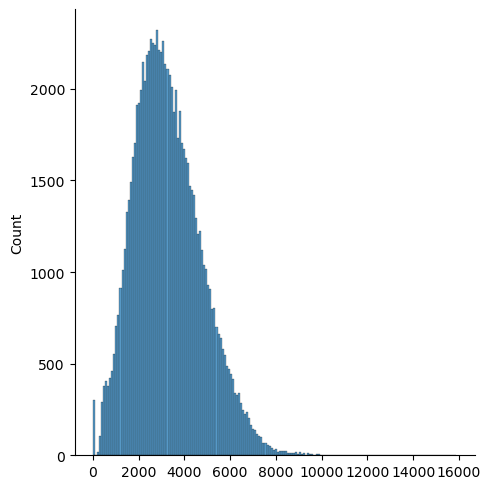

In [18]:
import seaborn as sns

sns.displot(travelTime.reshape(-1))